In [1]:
from typing import List, Tuple

import numpy as np
import openmm
import openmm.app
from openff.interchange import Interchange
from openff.interchange.interop.openmm import to_openmm_positions
from openff.units import unit
from openff.units.openmm import to_openmm
from openmm import unit as openmm_unit

from openff.toolkit import ForceField, Molecule, Topology

In [2]:
def prepare_simulation(
    openmm_topology: openmm.app.Topology,
    openmm_system: openmm.System,
    positions: unit.Quantity,
) -> openmm.app.Simulation:
    """Propagate an OpenMM System with Langevin dynamics."""
    time_step = 2 * openmm_unit.femtoseconds
    temperature = 300 * openmm_unit.kelvin
    friction = 1 / openmm_unit.picosecond
    integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

    trj_freq, data_freq = 100, 100

    simulation = openmm.app.Simulation(openmm_topology, openmm_system, integrator)

    n_virtual_sites = sum(atom.element is None for atom in openmm_topology.atoms())
    _positions = np.concatenate(
        (molecule.conformers[0], np.zeros((n_virtual_sites, 3))), axis=0
    )
    positions = to_openmm(_positions)
    simulation.context.setPositions(positions)

    # It's important to run energy minimization before computing velocities; otherwise the initial
    # velocities may be too high as a result of high initial forces, causing a crash
    # See https://github.com/openmm/openmm/issues/3736#issuecomment-1217250635
    simulation.minimizeEnergy()

    # Since we placed all virtual sites at [0.0, 0.0, 0.0], compute virtual site positions to avoid a crash
    simulation.context.computeVirtualSites()

    simulation.context.setVelocitiesToTemperature(temperature)

    pdb_reporter = openmm.app.PDBReporter("trajectory.pdb", trj_freq)
    state_data_reporter = openmm.app.StateDataReporter(
        "data.csv",
        data_freq,
        step=True,
        potentialEnergy=True,
        temperature=True,
        density=True,
    )
    simulation.reporters.append(pdb_reporter)
    simulation.reporters.append(state_data_reporter)

    return simulation


def run_simulation(simulation: openmm.app.Simulation, num_steps: int = 1000):
    import time

    print("Starting simulation")
    start = time.process_time()

    simulation.step(num_steps)

    end = time.process_time()
    print("Elapsed time %.2f seconds" % (end - start))
    print("Done!")

## Part 1: Run a short simulation with a virtual sites on sulfur lone pair and chloride groups

In [3]:
vsite_offxml = """<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <VirtualSites version="0.3">
        <VirtualSite
            type="DivalentLonePair"
            name="EP"
            smirks="[*:2]-[#16X2:1]-[*:3]"
            distance="0.70 * angstrom"
            charge_increment1="0.1205*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            charge_increment3="0.1205*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.0*kilocalories_per_mole"
            outOfPlaneAngle="54.71384225*degree"
            match="all_permutations" >
        </VirtualSite>
        <VirtualSite
            type="BondCharge"
            name="EP"
            smirks="[*:2][Cl:1]"
            distance="0.4*angstrom"
            charge_increment1="0.2*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.05*kilocalories_per_mole"
            match="all_permutations" >
        </VirtualSite>
        <VirtualSite
            type="BondCharge"
            name="EP"
            smirks="[*:2][F:1]"
            distance="0.4*angstrom"
            charge_increment1="0.2*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.05*kilocalories_per_mole"
            match="all_permutations" >
        </VirtualSite>
    </VirtualSites>
</SMIRNOFF>
"""
force_field = ForceField("openff-2.0.0.offxml", vsite_offxml)

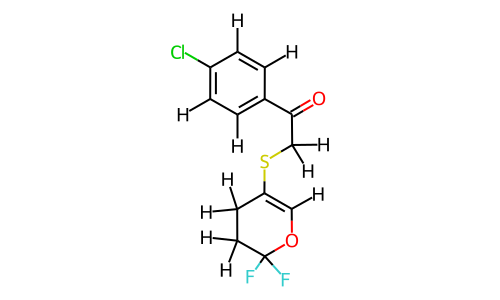

In [4]:
molecule = Molecule.from_smiles("c1cc(Cl)ccc1C(=O)CS[C]1=CO[C](F)(F)CC1")
molecule.generate_conformers(n_conformers=1)
molecule.visualize()

In [5]:
# Create an Interchange object, which stores information needed for OpenMM (and other engines)
# to understand virtual sites as applied by a force field

interchange = Interchange.from_smirnoff(
    force_field=force_field, topology=molecule.to_topology()
)

assert "VirtualSites" in interchange.handlers.keys()

/Users/mattthompson/miniconda3/envs/offtk-examples/lib/python3.9/site-packages/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.topology_atoms is deprecated. Use Topology.atoms instead.
  warnings.warn(


At this point, each of our OpenFF objects have processed and stored all of the information needed to run a simulation in OpenMM. Next we need to do some conversions prepare the OpenMM objects. First we'll make an _OpenMM_ `Topology` and a corresponding _OpenMM_ `System`, each containing virtual sites.

In [6]:
# Note that interchange.topology.to_openmm() uses a different code path that DOES NOT include virtual sites
openmm_topology: openmm.app.Topology = interchange.to_openmm_topology()

openmm_system: openmm.System = interchange.to_openmm(combine_nonbonded_forces=True)

In [7]:
# Retrieve the number of virtualsites in this system/topology by counting
# the number of "Atoms" in the OpenMM `Toppology` with a `None` element
# (this method returns virtual sites as welll, despite the name) ...
n_virtual_sites = sum(atom.element is None for atom in openmm_topology.atoms())

# or the number of particles in the OpenMM `System` with zero mass
assert n_virtual_sites == sum(
    openmm_system.getParticleMass(index)._value == 0
    for index in range(openmm_system.getNumParticles())
)

# This can also be done by inspecting the virtual site handler in the Interchange object
assert n_virtual_sites == len(interchange["VirtualSites"].slot_map)

print(f"There are {n_virtual_sites} virtual particles in this topology.")

There are 5 virtual particles in this topology.


In [8]:
simulation = prepare_simulation(
    openmm_topology=openmm_topology,
    openmm_system=openmm_system,
    positions=to_openmm_positions(interchange),
)

run_simulation(simulation, 10000)

Starting simulation
Elapsed time 2.05 seconds
Done!


In [9]:
import mdtraj

# Visualize the trajectory. There will probably be errant bonds drawn between atoms and virtual sites.
import nglview

nglview.show_mdtraj(mdtraj.load("trajectory.pdb"))

NGLWidget(max_frame=99)

## Part 2: Numerical comparison of OpenMM's TIP5P and an equivalent SMIRNOFF implementation

Parameterizes a water box with OpenFF and OpenMM force fields. Currently set up
to use a TIP5P definition. The code examines the geometry and energy between the
two, and examines cases where minimization is performed. Specifically, the code
compares the four possible combinations:
    - oFF and oMM geometry/energy, minimized separately and then compared
    - oFF and oMM geometry/energy using no minimization
    - Geometry minimized using oFF, then a single point is done with oMM
    - Geometry minimized using oMM, then a single point is done with oFF

The virtual site definitions give differences in geometry and energy mostly due
to how they were defined from their parent atoms. OpenMM uses an OutOfPlaneSite
definition, whereas OpenFF uses the LocalCoordinatesSite definition (both are
OpenMM types). In the OutOfPlaneSite definition, both angle and distance are
variable since the defined out-of-plane angle depends on a weighted vector cross.
The cross is a function of the O-H vectors, so the virtual sites are sensitive
to the molecular geometry. In the OpenFF version, the distance is fixed to a constant
value, and the out-of-plane angle is explicitly required in the OpenFF spec.

In this example, the OpenFF parameter definition (the "offxml") is a string
further below in the `main` function, and can be easily modified to explore
force field parameterization. The OpenMM definition is loaded from its internal
default location, and acts as a reference. One can change this this to a different
filename to compare other force fields.

This example is somewhat hardcoded to operate on water molecules, but can be easily
modified to examine other cases as well. The only major assumption is that the
system is homogenous, i.e., all of the molecules are same. The reason this is
assumed is mostly due to the difference in how virtual sites are handled between
OpenFF and OpenMM. Whereas OpenMM interleaves the virtual site particles between
the atomic particles, OpenFF instead aggregates all virtual sites and places them
last. The code below does assume that, barring this difference, the virtual sites
are added in the same order.

The example begins in `run_tests` by defining a grid of water molecules, with
the default being a single water molecule (Nx=1, Ny=1, Nz=1). From this, the
calculations described in the first paragraph above are performed. The energy
difference and distance between the two geometries, per atom, is then reported.
There are commented lines that print the entire set of coordinates, and can be
uncommented if desired.

In [10]:
def _collate_virtual_site_positions(atom_positions: np.ndarray) -> np.ndarray:
    """Given an array of atomic positions of water, collate virtual particles between molecules."""
    padded_positions = np.zeros(shape=(2, 3))
    num_atoms_per_mol = 3

    def mol_positions(i, atom_positions):
        this_mol_atom_coordinates = atom_positions[
            i * num_atoms_per_mol : (i + 1) * num_atoms_per_mol
        ]
        return np.vstack([this_mol_atom_coordinates, padded_positions])

    return np.vstack([mol_positions(i, atom_positions) for i in range(2)])

In [11]:
def _evaluate_positions_and_energy(
    openmm_topology: openmm.app.Topology,
    openmm_system: openmm.app.Simulation,
    particle_positions: openmm_unit.Quantity,
    minimize=False,
) -> Tuple[np.ndarray, unit.Quantity]:
    """
    Calculate particle positions and potential energy of the a system.

    Parameters
    ----------
    openmm_topology: openmm.app.Topology, OpenMM Topology
    openmm_system: openmm.app.System, OpenMM System
    particle_positions: openff.units.unit.Quantity, (N, 3) array of positions in nanometers
    minimize: bool, Whether or not to perform an energy minimization before calculating energy

    Returns
    -------
    positions: numpy.ndarray, array of particle positions (as nanometers)
    energy: openmm.unit.Quantity, The potential energy of the systems

    """

    integrator = openmm.LangevinIntegrator(
        300 * openmm_unit.kelvin,
        1 / openmm_unit.picosecond,
        0.002 * openmm_unit.picoseconds,
    )

    sim = openmm.app.Simulation(openmm_topology, openmm_system, integrator)

    sim.context.setPositions(particle_positions)
    sim.context.applyConstraints(1e-5)

    if minimize:
        sim.minimizeEnergy()

    state = sim.context.getState(getEnergy=True, getPositions=True)
    ene = state.getPotentialEnergy()
    pos = openmm_unit.Quantity(
        [
            list(xyz)
            for xyz in state.getPositions().value_in_unit(openmm_unit.nanometer)
        ],
        openmm_unit.nanometer,
    )

    return pos, ene

In [12]:
def build_water_lattice(
    num_duplicates: List[int] = [1, 1, 1],
    spacing: List[float] = [2.0, 2.0, 2.0],
) -> List[Molecule]:
    """
    Generate a box of water molecules as OpenFF Molecules

    Parameters
    ----------
        num_duplicates: List[int], The number of molecules in each dimension
        spacing: List[float], The spacing between the molecules in each dimension, implicitly in Angstrom

    Returns
    -------
        water_box: List[Molecule], A list of Molecule objcets with a 3D conformation
    """
    Lx, Ly, Lz = (num_duplicates[i] * spacing[i] for i in range(3))
    Z, Y, X = np.mgrid[
        0 : Lz : spacing[0],
        0 : Ly : spacing[1],
        0 : Lx : spacing[2],
    ]
    XYZ = [list(xyz) for xyz in zip(X.flat, Y.flat, Z.flat)]

    water_box = list([None] * len(XYZ))
    water_reference = Molecule.from_mapped_smiles("[O:1]([H:2])[H:3]")
    water_reference.atoms[0].name = "O"
    water_reference.atoms[1].name = "H1"
    water_reference.atoms[2].name = "H2"
    # Add ideal TIP5P geometry
    water_reference.add_conformer(
        [[0.0, 0.0, 0.0], [-0.7815, 0.5526, 0.0], [0.7815, 0.5526, 0.0]] * unit.angstrom
    )

    for i, xyz in enumerate(XYZ):
        water_box[i] = Molecule(water_reference)
        water_box[i].conformers[0] = water_box[i].conformers[0] + xyz * unit.angstrom

    return water_box

In [13]:
def evaluate_openmm(
    water: List[Molecule],
    openmm_force_field: openmm.app.ForceField,
    minimize: bool = False,
):
    """
    Given a list of molecules and a force field definition, calculate the
    positions and energy.

    Parameters
    ----------
        water: List[Molecule], each with a 3D conformation
        openmm_force_field: openmm.app.ForceField, OpenMM ForceField object
        minimize: bool, default = False, whether the structure should be minimized

    Returns
    -------
        xyz: List The coordinates of all particles in the system (OpenMM ordering)
        ene: float, The potential energy
    """

    # First, get an OpenMM Topology and atom positions with no virtual sites
    _topology: openmm.app.Topology = Topology.from_molecules(water).to_openmm()

    atom_positions_unitless = np.vstack(
        [mol.conformers[0].m_as(unit.nanometer) for mol in water]
    )
    atom_positions = openmm_unit.Quantity(
        atom_positions_unitless, openmm_unit.nanometer
    )

    # Use OpenMM's Modeller to add virtual particles as perscribed by the force field
    modeller = openmm.app.Modeller(_topology, atom_positions)
    modeller.addExtraParticles(openmm_force_field)

    # This topology includes virtual particles, so we can use it to create a System
    topology = modeller.getTopology()

    system: openmm.System = openmm_force_field.createSystem(
        topology, nonbondedMethod=openmm.app.NoCutoff
    )

    # Add positions of virtual particles now that the topology includes them
    particle_positions = openmm_unit.Quantity(
        _collate_virtual_site_positions(atom_positions), openmm_unit.nanometer
    )

    return _evaluate_positions_and_energy(
        topology, system, particle_positions, minimize=minimize
    )

In [14]:
def evaluate_openff(
    water: List[Molecule],
    force_field: ForceField,
    minimize: bool = False,
):
    """
    Given a list of molecules and a force field definition, calculate the
    positions and energy.

    Parameters
    ----------
        water: List[Molecule], each with a 3D conformation
        force_field: ForceField, an OpenFF ForceField object
        minimize: boolean, default= False, whether the structure should be minimized

    Returns
    -------
        xyz: list The coordinates of all particles in the system (OpenMM ordering)
        ene: float, The potential energy
    """
    openff_topology = Topology.from_molecules(water)
    interchange = Interchange.from_smirnoff(force_field, openff_topology)

    return _evaluate_positions_and_energy(
        interchange.to_openmm_topology(),
        interchange.to_openmm(combine_nonbonded_forces=True),
        to_openmm(to_openmm_positions(interchange)),
    )

In [15]:
def print_info(xyz, ene, name, crd_units=unit.angstrom) -> str:
    print(f"Results for: {name}\nEnergy: {ene}\nCoordinates:{xyz * crd_units}\n")

In [16]:
tip5p_offxml = """<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <LibraryCharges version="0.3">
            <LibraryCharge name="tip5p" smirks="[#1:1]-[#8X2H2+0:2]-[#1:3]" charge1="0.*elementary_charge" charge2="0.*elementary_charge" charge3="0.*elementary_charge"/>
    </LibraryCharges>
    <vdW version="0.3" potential="Lennard-Jones-12-6" combining_rules="Lorentz-Berthelot" scale12="0.0" scale13="0.0" scale14="0.5" scale15="1.0" switch_width="0.0 * angstrom" cutoff="10.0 * angstrom" method="cutoff">
            <Atom smirks="[#1:1]-[#8X2H2+0]-[#1]" epsilon="0. * mole**-1 * kilojoule" id="n35" sigma="1.0 * nanometer"/>
            <Atom smirks="[#1]-[#8X2H2+0:1]-[#1]" epsilon="0.66944 * mole**-1 * kilojoule" id="n35" sigma="0.312 * nanometer"/>
    </vdW>
     <Bonds version="0.4" potential="harmonic" fractional_bondorder_method="AM1-Wiberg" fractional_bondorder_interpolation="linear">
        <Bond smirks="[#1:1]-[#8X2H2+0:2]-[#1]" length="0.9572 * angstrom" k="462750.4 * nanometer**-2 * mole**-1 * kilojoule" id="b1" />
    </Bonds>
    <Angles version="0.3" potential="harmonic">
        <Angle smirks="[#1:1]-[#8X2H2+0:2]-[#1:3]" angle="1.82421813418 * radian" k="836.8 * mole**-1 * radian**-2 * kilojoule" id="a1" />
    </Angles>
    <VirtualSites version="0.3">
        <VirtualSite
            type="DivalentLonePair"
            name="EP"
            smirks="[#1:2]-[#8X2H2+0:1]-[#1:3]"
            distance="0.70 * angstrom"
            charge_increment1="0.0*elementary_charge"
            charge_increment2="0.1205*elementary_charge"
            charge_increment3="0.1205*elementary_charge"
            sigma="10.0*angstrom"
            epsilon="0.0*kilocalories_per_mole"
            outOfPlaneAngle="54.735*degree"
            match="all_permutations" >
        </VirtualSite>
    </VirtualSites>
    <Electrostatics version="0.3" method="PME" scale12="0.0" scale13="0.0" scale14="0.833333" scale15="1.0" switch_width="0.0 * angstrom" cutoff="9.0 * angstrom"/>
</SMIRNOFF>
"""


constraints = """
  <Constraints version="0.3">
    <Constraint smirks="[#1:1]-[#8X2H2+0:2]-[#1]" id="c1" distance="0.9572 * angstrom"/>
    <Constraint smirks="[#1:1]-[#8X2H2+0]-[#1:2]" id="c2" distance="1.5139006545247014 * angstrom"/>
  </Constraints>
"""

In [17]:
# The TIP5P force field in SMIRNOFF format
openff_force_field = ForceField(tip5p_offxml)

# The standard OpenMM definition of tip5p
openmm_force_field = openmm.app.ForceField("tip5p.xml")

In [18]:
minimize = False

num_duplicates = (2, 1, 1)  # 2x2x2 = 8 water molecules
spacing = (3.0, 3.0, 3.0)  # water spaced 3A apart in each direction

np.set_printoptions(formatter={"float_kind": "{:13.10f}".format})

waters = build_water_lattice(num_duplicates, spacing)

off_crds, off_ene = evaluate_openff(waters, openff_force_field, minimize=minimize)
off_crds = np.array(off_crds.value_in_unit(openmm_unit.angstrom))

omm_crds, omm_ene = evaluate_openmm(waters, openmm_force_field, minimize=minimize)
omm_crds = np.array(omm_crds.value_in_unit(openmm_unit.angstrom))

print_info(
    np.linalg.norm(off_crds - omm_crds, axis=1),
    off_ene - omm_ene,
    "OpenFF - OpenMM norm",
)

coordinate_difference = np.linalg.norm(off_crds - omm_crds) / np.prod(num_duplicates)
energy_difference = abs(off_ene - omm_ene)


# For some reason, there is a slight coordinate/energy difference between the OpenFF
# TIP5P virtual sites and the OpenMM TIP5P virtual sites. The energy difference appears
# to be entirely due to slightly different geometry.
assert (
    coordinate_difference < 0.04
), f"Coordinates differ by a norm of {coordinate_difference}"
assert (
    energy_difference < 1.0 * openmm_unit.kilojoule_per_mole
), f"Energies differ by {energy_difference}"

Results for: OpenFF - OpenMM norm
Energy: 0.6343574523925781 kJ/mol
Coordinates:[0.0 0.0 0.0 0.02741583295825021 0.02741583295825021 0.0 0.0 0.0 0.02741583295825033 0.02741583295825033] angstrom



/Users/mattthompson/miniconda3/envs/offtk-examples/lib/python3.9/site-packages/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.topology_atoms is deprecated. Use Topology.atoms instead.
  warnings.warn(
